## DIGIT Force Calibration

### Overview

This notebook compares measurements collected across different objects, motions, and FSR placements, establishes thresholds for three discrete force levels, and calibrates voltage readings to Newtons. Together, these steps provide a reliable baseline for using an FSR mounted on the rear of a DIGIT tactile sensor.

During operation, the forefinger rests on the rear-mounted FSR to control the applied pressure, while the thumb and middle finger grip the sides of the DIGIT purely for stability. All cables are arranged so they remain clear of the workspace and do not interfere with data collection.

All measurements were taken in a standard home office environment at an average room temperature of approximately 20.5 °C.

### Imports and Useful Functions

In [458]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix

In [459]:
def plot_voltage_over_time(df, column_name):
    """
    Plots the voltage over time for different values in the specified column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to analyse.
    """
    # Extract possible values for the specified column
    vals = df[column_name].unique()

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot the voltage for each value
    for val in vals:
        data = df[df[column_name] == val]
        sns.lineplot(data=data, x='time_s', y='voltage', label=val)
    
    # Labels and title
    plt.title('FSR Voltage Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

In [460]:
def plot_voltage_by_force(df, type='box'):
    """
    Plots a boxplot or violin plot of voltage grouped by force levels.

    Args:
        df (pd.DataFrame): The input DataFrame.
        type (str): Type of plot to create ('box' or 'violin').
    """
    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot based on the specified type
    if type == 'box':
        ax = sns.boxplot(
            data=df,
            x='force',
            y='voltage',
        )
    elif type == 'violin':
        ax = sns.violinplot(
            data=df,
            x='force',
            y='voltage',
            inner='quartile',  # Show median + quartiles inside the violin
            cut=0,  # Do not extend beyond min/max of data
        )
    
    # Labels and title
    ax.set_title('Voltage Distribution per Force Level', fontsize=14, pad=15)
    ax.set_xlabel('Force Level', fontsize=12)
    ax.set_ylabel('Voltage (V)', fontsize=12)
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [461]:
def threshold_cm(actual, classified, labels):
    """
    Plots a confusion matrix comparing actual vs classified force levels.

    Args:
        actual (list): List of actual force levels.
        classified (list): List of classified force levels.
        labels (list): List of force level labels.
    """
    # Build the confusion matrix
    cm = confusion_matrix(actual, classified, labels=labels)

    # Plot as heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )

    # Labels and title
    plt.title("Confusion Matrix for Force-Level Thresholds")
    plt.xlabel("Classified Force Level")
    plt.ylabel("Actual Force Level")

    # Show plot
    plt.tight_layout()
    plt.show()

In [462]:
def remove_iqr_outliers(df, col, k=1.5):
    """
    Remove IQR outliers from a Pandas DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        col (str): Name of the column to check for outliers.
        k (float, optional): IQR multiplier used to define outlier thresholds.
            Defaults to 1.5.

    Returns:
        pandas.DataFrame: DataFrame with outliers removed based on the IQR rule.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR

    # Keep only non-outliers
    return df[(df[col] >= lower) & (df[col] <= upper)]

### Object Comparison

I carried out a series of long-press tests with the DIGIT sensor on five different objects, recording both the raw FSR values and the converted voltages for two seconds at approximately 20 Hz. Each long press began with light contact before gradually increasing the applied force until reaching a full press. For all object trials, the sensor was held facing downwards to maintain a consistent pressing orientation.

In [463]:
# Load the CSV data
df_press = pd.read_csv('data/press_data.csv')
df_press.head()

,object,time_s,raw,voltage
0,beans,0.001,320,0.0161
1,beans,0.052,944,0.0475
2,beans,0.103,304,0.0153
3,beans,0.153,896,0.0451
4,beans,0.204,320,0.0161


Below, I plot the FSR voltage over time for each object to assess whether any visible differences emerge across objects.

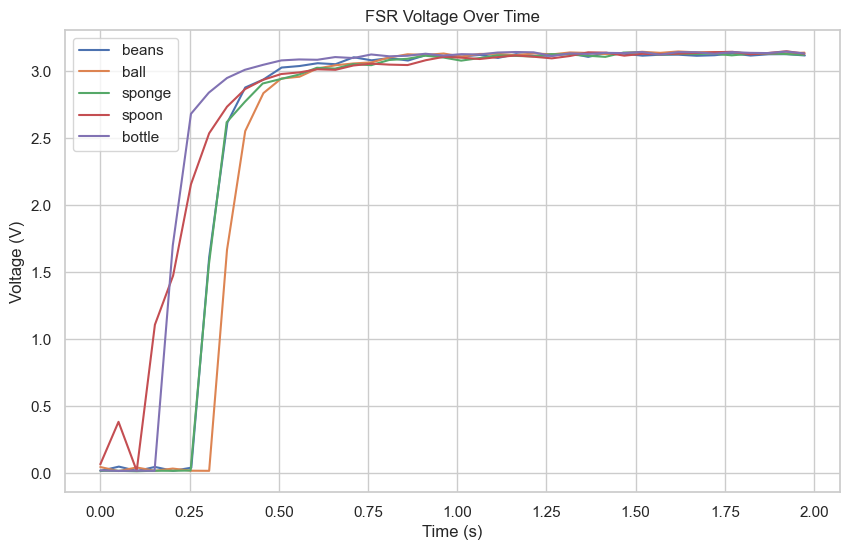

In [464]:
# Plot the curves for each object in the press data
plot_voltage_over_time(df_press, 'object')

The traces are broadly very similar across objects, with all reaching nearly the same steady-state voltage once fully pressed. Minor differences in the ramp-up phase, as well as the small spike at the start of one trial, are expected and likely due to normal human variation in the pressing motion. Overall, the steady-state output is consistent and largely object-independent.

### FSR Position Comparison

I carried out a series of long-press tests using the DIGIT sensor on a tennis ball, chosen for its uniform texture and geometry, to examine whether the FSR’s output varied with press orientation. The sensor was pressed firmly against the ball from three directions: vertically downward onto the top surface, horizontally into the right side, and upward into the underside. I held the ball in my other hand throughout to prevent any movement. In these trials I maintained the initial contact position slightly longer than in the object long-press tests to ensure that the early portion of the data was reliably captured.

In [465]:
# Load the CSV data
df_press_pos = pd.read_csv('data/press_position_data.csv')
df_press_pos.head()

,position,time_s,raw,voltage
0,top,0.000,272,0.0137
1,top,0.051,784,0.0395
2,top,0.102,320,0.0161
3,top,0.153,592,0.0298
4,top,0.204,208,0.0105


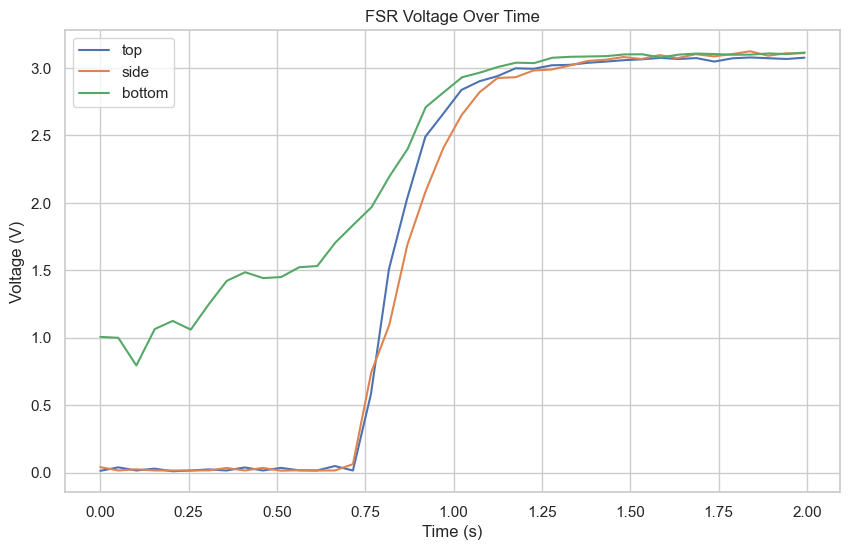

In [466]:
# Plot the curves for each position in the press position data
plot_voltage_over_time(df_press_pos, 'position')

The plot shows that the voltage profiles for the top and side orientations are almost identical across the entire two-second press. Both produce the same near-zero baseline, similar force-increase trajectories, and comparable saturation values. In contrast, the bottom orientation begins at a noticeably higher voltage before the press starts. This elevated baseline is likely caused by the weight of the DIGIT sensor resting on the FSR when the sensor is facing upwards, resulting in an initial pre-load that does not occur in the other orientations.

Because this pre-load artificially shifts the voltage values and does not reflect the intended force-application behaviour, future data collection will be limited to downward and sideways orientations, including intermediate angles between them.

### Force Level Thresholds

I collected FSR readings by performing sliding and rotational motions across five different objects under three manually applied force conditions. Level 1 involved making contact with the object without exerting pressure, Level 2 introduced light pressure resulting in slight deformation, and Level 3 applied firm pressure, producing marked deformation while remaining within safe limits for both the sensor and the object.  

Both sliding and rotational motions were included because these will be used in the final dataset, and it was necessary to ensure that the force readings remained consistent across the two movement types.

The aim was to record both raw and converted voltage readings in order to gauge suitable thresholds for the three discrete force levels.

In [467]:
# Load the CSV data
df_motion = pd.read_csv('data/motion_data.csv')
df_motion.head()

,object,motion,force,raw,voltage
0,beans,slide,1,336,0.0169
1,beans,slide,1,464,0.0234
2,beans,slide,1,320,0.0161
3,beans,slide,1,256,0.0129
4,beans,slide,1,336,0.0169


In [468]:
# Initial stats
force_stats = df_motion.groupby('force')['voltage'].describe()
force_stats

,count,mean,std,min,25%,50%,75%,max
force,,,,,,,,
1,500.0,0.022411,0.010863,0.0073,0.0161,0.0169,0.0290,0.0540
2,500.0,2.599554,0.552760,0.0161,2.6104,2.7859,2.9064,3.0107
3,500.0,3.054284,0.053176,2.5828,3.0357,3.0574,3.0792,3.1373


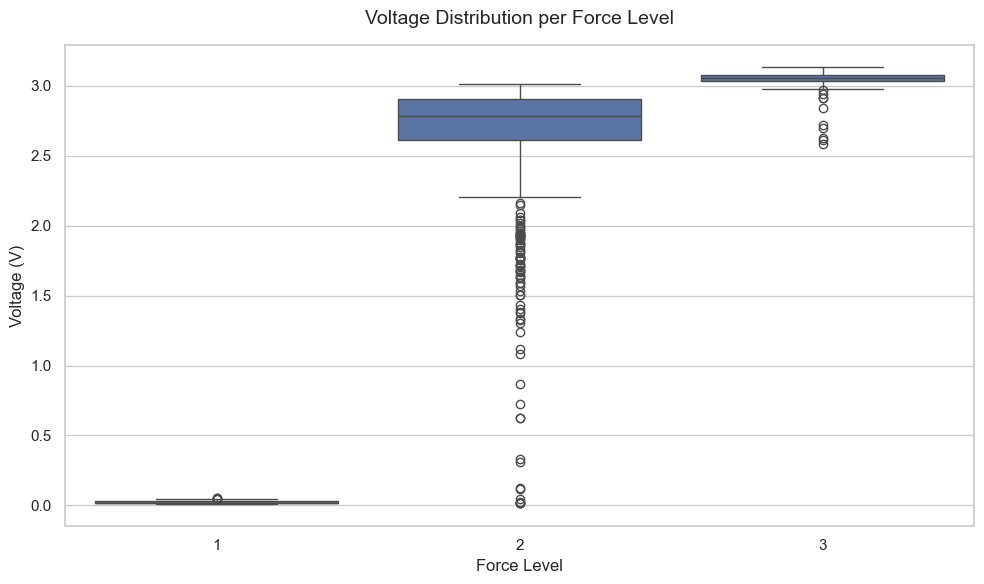

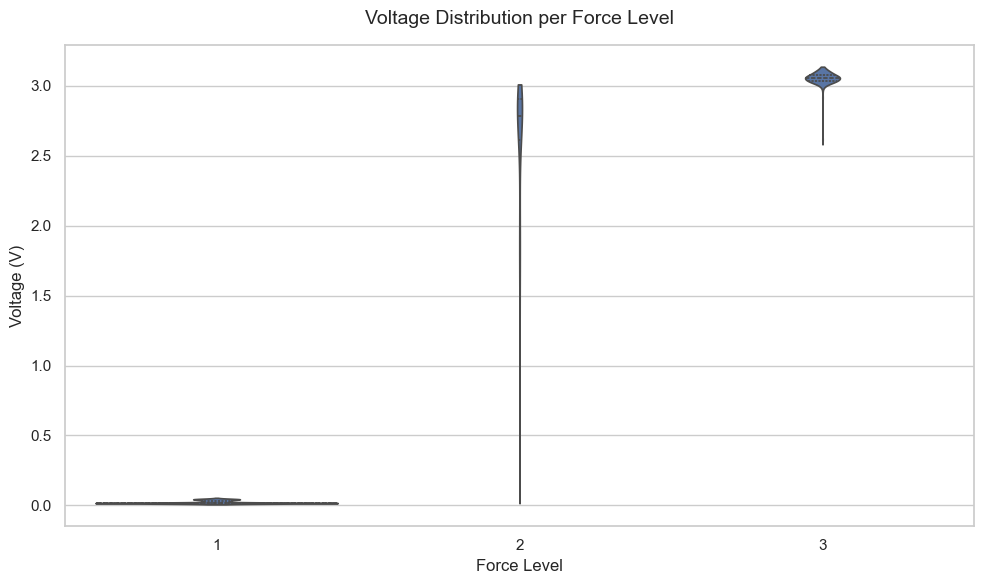

In [469]:
# Show boxplot and violin plots for the data
plot_voltage_by_force(df_motion, type='box')
plot_voltage_by_force(df_motion, type='violin')

In [470]:
# Remove outliers from motion data
df_motion_clean = (
    df_motion
    .groupby('force', group_keys=False)
    .apply(remove_iqr_outliers, col='voltage', k=1.5)
)
 
df_motion_clean['force'].value_counts()

/var/folders/wp/c8l2zvtj0s74nmvn23mcmxnw0000gn/T/ipykernel_84300/2830996492.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_iqr_outliers, col='voltage', k=1.5)


force
1    495
3    490
2    425
Name: count, dtype: int64

In [471]:
# Cleaned stats
force_stats_clean = df_motion_clean.groupby('force')['voltage'].describe()
force_stats_clean

,count,mean,std,min,25%,50%,75%,max
force,,,,,,,,
1,495.0,0.022124,0.010533,0.0073,0.0161,0.0169,0.0270,0.0483
2,425.0,2.799248,0.152900,2.2089,2.7166,2.8391,2.9140,3.0107
3,490.0,3.059829,0.030580,2.9785,3.0367,3.0582,3.0812,3.1373


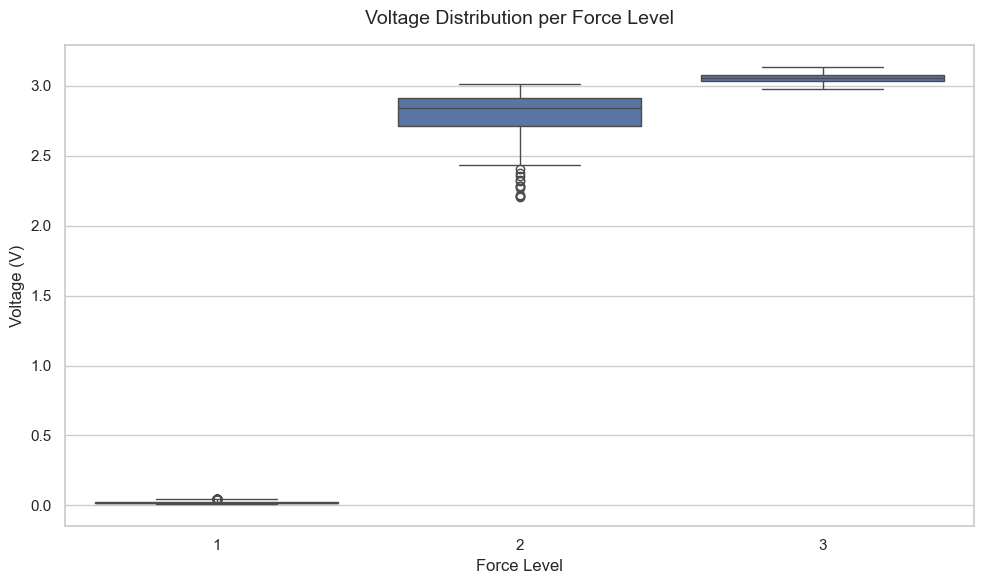

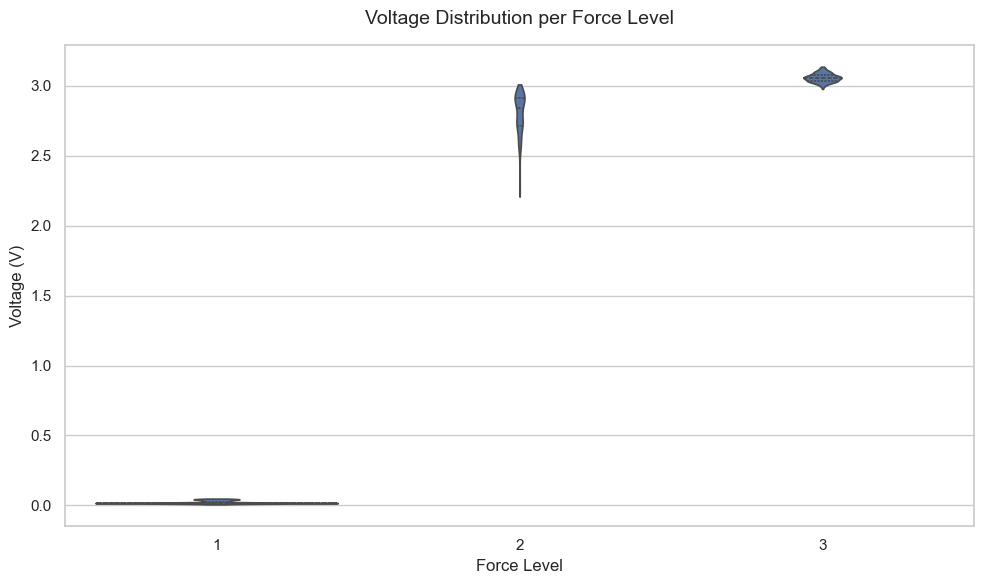

In [472]:
# Show boxplot and violin plots for the cleaned data
plot_voltage_by_force(df_motion_clean, type='box')
plot_voltage_by_force(df_motion_clean, type='violin')

To support the visual and statistical analysis above, the following table summarises the final force-level voltage thresholds that will be used for classification.

| Force Level | Voltage Range (V) |
| ----------- | ----------------- |
| **Level 1** | 0 – 0.99          |
| **Level 2** | 1 – 2.99          |
| **Level 3** | 3+                |


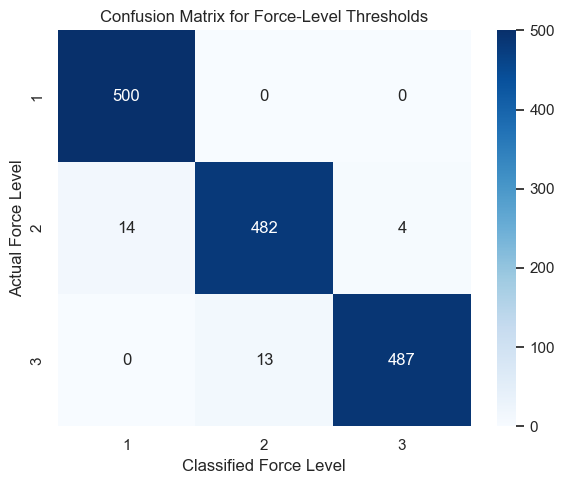

In [473]:
# Force-level thresholds
def classify_thresholds(v):
    if v < 0.99:
        return 1
    elif v < 2.99:
        return 2
    else:
        return 3

# Classify based on thresholds
df_motion['classified'] = df_motion['voltage'].apply(classify_thresholds)

# Confusion matrix
threshold_cm(df_motion['force'], df_motion['classified'], labels=[1,2,3])

In [474]:
# Overall accuracy
overall_acc = (df_motion['classified'] == df_motion['force']).sum() / len(df_motion)
print(f"Overall accuracy: {overall_acc:.2f}%")

# Per-class accuracy
per_class_acc = df_motion.groupby('force').apply(
    lambda g: (g['classified'] == g['force']).sum() / len(g)
)

print('\nAccuracy per force level:')
print(per_class_acc)

Overall accuracy: 0.98%

Accuracy per force level:
force
1    1.000
2    0.964
3    0.974
dtype: float64


/var/folders/wp/c8l2zvtj0s74nmvn23mcmxnw0000gn/T/ipykernel_84300/3229584455.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_acc = df_motion.groupby('force').apply(


### Voltage to Newtons Calibration

Notes:  
Remove outliers   
Average  
Convert to N  
Fit curve  
Run inference on new V and get for each threshold  

Cables not touching, placed in centre of scales